This is a part of [Github Repository](https://github.com/rrpronaldo/colorful_image_colorization)

In [1]:
import matplotlib.pyplot as plt
import os
from google.colab import drive
from tensorflow.python.client import device_lib

import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/Zhang_Repository/colorization')

# Custom library responsible to colorize images
from colorizers import *

#Function to get GPUs available in the environment
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

GPUs_list = get_available_gpus()

Mounted at /content/drive


In [27]:
# load colorizers
colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()

if(GPUs_list):
	colorizer_eccv16.cuda()
	colorizer_siggraph17.cuda()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth" to /root/.cache/torch/hub/checkpoints/siggraph17-df00044c.pth


In [28]:
def colorize_image(image):
  # default size to process images is 256x256
  # grab L channel in both original ("orig") and resized ("rs") resolutions
  (tens_l_orig, tens_l_rs) = preprocess_img(image, HW=(256,256))
  if(GPUs_list):
    tens_l_rs = tens_l_rs.cuda()

  # colorizer outputs 256x256 ab map
  # resize and concatenate to original L channel
  img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
  out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
  out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

  return out_img_eccv16, out_img_siggraph17

In [29]:
def split_and_pooling(image_lab, kernel = [256,256], strides = [56, 56]):
    """
        Kernel = Size of frame that is pass through the neural network 
        Strides = Size of the kernel offset in each iteration
    """
    #result = np.zeros((image_lab.shape[0], image_lab.shape[1], 2))
    result_eccv16, result_siggraph17 = colorize_image(image_lab)   
    result_siggraph17 = result_siggraph17
    result_eccv16 = result_eccv16

    rows = image_lab.shape[0]
    columns = image_lab.shape[1]

    #Criar array com os índices de rows e columns para fazer o corte e separar a matriz
    rows_list = list(np.arange(0, rows, strides[0]))
    columns_list = list(np.arange(0, columns, strides[1]))

    print(rows_list)
    print(columns_list)

    #Percorrer a matriz 
    row_ini = 0
    row_end = 0
    for i, row in enumerate(rows_list):
        if (row_end == rows):
            break
        elif ((rows_list[i] + kernel[0]) > rows):
            row_ini = rows - kernel[0]
            row_end = rows
        else:
            row_ini = rows_list[i]
            row_end = row_ini + kernel[0]
        #print(row_ini, row_end)
        column_ini = 0
        column_end = 0
        for j, col in enumerate(columns_list):
            if (column_end == columns):
                break
            elif ((columns_list[j] + kernel[1]) > columns):
                column_ini = columns - kernel[1]
                column_end = column_ini + kernel[1]
            else:
                column_ini = columns_list[j]
                column_end = column_ini + kernel[1]
            
            #print(column_ini, column_end)
            chunk_image = image_lab[row_ini:row_end, column_ini:column_end]

            #Selecionar a parte/pedaço nos mesmos índices do resultado
            chunk_result_siggraph17 = result_siggraph17[row_ini:row_end, column_ini:column_end]
            chunk_result_eccv16 = result_eccv16[row_ini:row_end, column_ini:column_end]

            #Colorir a parte da imagem
            #result_eccv16, result_siggraph17 = colorize_image(image_lab)  
            chunk_color_eccv16, chunk_color_siggraph17 =  colorize_image(chunk_image)
            
            #Calcular o máximo pixel entre os dois pedaços da imagem e salvar no resultado
            #Média: (chunk_image + chunk_result) / 2.0
            #result[row_ini:row_end, column_ini:column_end] = np.maximum(chunk_color, chunk_result)
            #result[row_ini:row_end, column_ini:column_end] = chunk_color
            
            result_eccv16[row_ini:row_end, column_ini:column_end]     = (chunk_color_eccv16 + chunk_result_eccv16) / 2.0
            result_siggraph17[row_ini:row_end, column_ini:column_end] = (chunk_color_siggraph17 + chunk_result_siggraph17) / 2.0

            #Máximo: Resulta em muitas áreas vermelhas
            #result_eccv16[row_ini:row_end, column_ini:column_end]     = np.maximum(chunk_color_eccv16,chunk_result_eccv16)
            #result_siggraph17[row_ini:row_end, column_ini:column_end] = np.maximum(chunk_color_siggraph17,chunk_result_siggraph17)
            

        
    print('\n')
    return result_eccv16, result_siggraph17

In [30]:
images_folder = './imgs/'
imagens_list = os.listdir(images_folder)
imagens_list

['mark_twain.jpg',
 'albert_einstein.jpg',
 'Escola_Linha_Marcolin.jpg',
 'Jose Quartel.jpg',
 'Jose Quartel 3.jpg',
 'Jose Quartel 4 0.jpg',
 'Jose Irma Montagem.jpg',
 'Jose Quartel 4 Top 6.jpg',
 'Jose Quartel 4 Top 7 226.jpg',
 'Jose_Quartel_6.jpg']

In [31]:
image = imagens_list[5]

img_path = images_folder + image
filename, extension = os.path.splitext(image)
print("Colorindo:", image)

#Load image
img = load_img(img_path)

result_eccv16, result_siggraph17 = split_and_pooling(img, kernel = [512,512], strides = [28, 28])
#result_eccv16, result_siggraph17 = colorize_image(img)

#Save images in the output folder
output_folder = './imgs_out/'
#plt.imsave(output_folder + filename + '_eccv16.png', out_img_eccv16)
#plt.imsave(output_folder + filename + '_siggraph17.png', out_img_siggraph17)

Colorindo: Jose Quartel 4 0.jpg
[0, 28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336, 364, 392, 420, 448, 476, 504, 532, 560, 588, 616, 644, 672, 700]
[0, 28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336, 364, 392, 420, 448, 476, 504, 532, 560, 588, 616, 644, 672, 700, 728, 756, 784, 812, 840, 868, 896, 924, 952, 980, 1008, 1036]




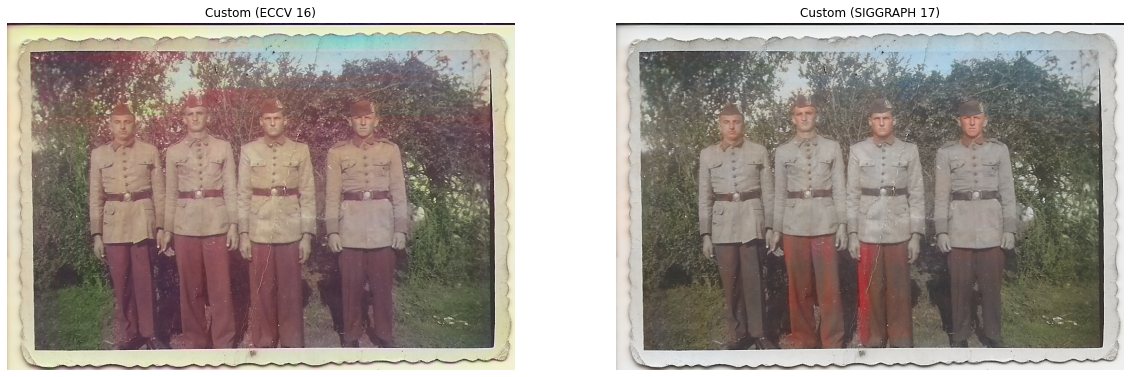

In [32]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(result_eccv16)
ax.set_title('Custom (ECCV 16)')
ax.axis('off')

ax2.imshow(result_siggraph17)
ax2.set_title('Custom (SIGGRAPH 17)')
ax2.axis('off')

plt.show()

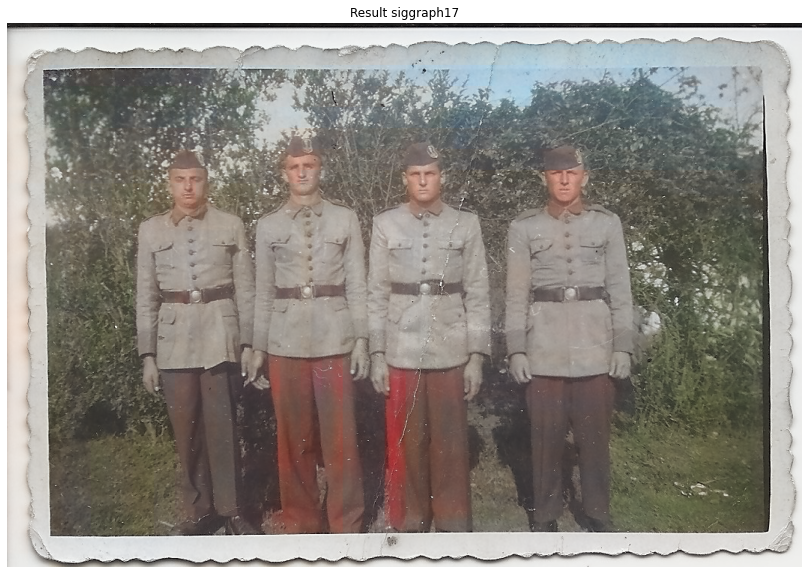

In [33]:
plt.figure(figsize=(15,10))
plt.imshow(result_siggraph17)
plt.title('Result siggraph17')
plt.axis('off')
plt.show()

In [ ]:
#plt.imsave('./imgs_out/Escola_Linha_Marcolin_eccv16_c_st28.png', result_eccv16)
#plt.imsave('./imgs_out/Escola_Linha_Marcolin_siggraph17_c_st28.png', result_siggraph17)

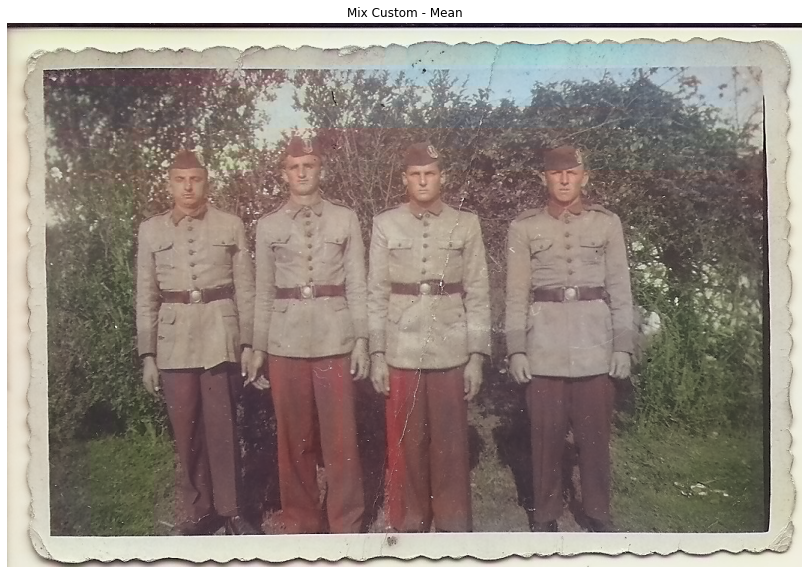

In [34]:
img_mean = ((result_eccv16) + (result_siggraph17)) / 2.0
#img_mean = np.maximum(result_eccv16, result_siggraph17)
#plt.imsave('./imgs_out/Escola_Linha_Marcolin_siggraph17_c_st28_mean.png', img_mean)
plt.figure(figsize=(15,10))
plt.imshow(img_mean)
plt.title('Mix Custom - Mean')
plt.axis('off')
plt.show()

In [ ]:
#plt.imsave('./imgs_out/Escola_Linha_Marcolin_eccv16_c_st128.png', result_test)


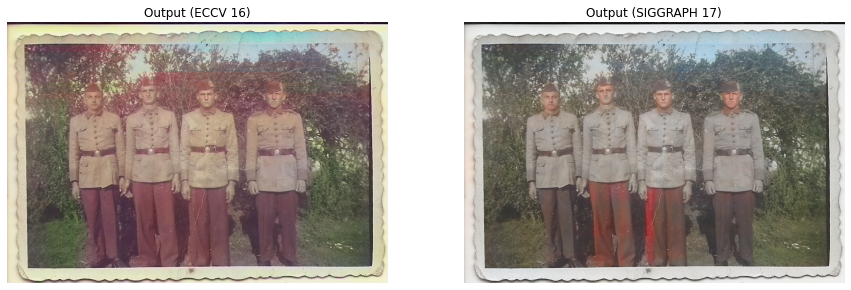

In [36]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(result_eccv16)
ax.set_title('Output (ECCV 16)')
ax.axis('off')

ax2.imshow(result_siggraph17)
ax2.set_title('Output (SIGGRAPH 17)')
ax2.axis('off')

plt.show()

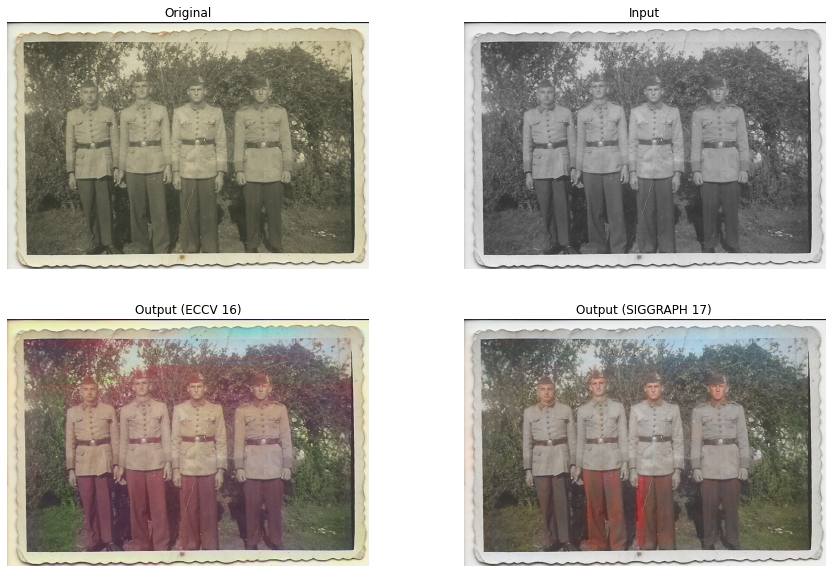

In [38]:
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
if(GPUs_list):
  tens_l_rs = tens_l_rs.cuda()

# resize and concatenate to original L channel
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(result_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(result_siggraph17)
plt.title('Output (SIGGRAPH 17)')
plt.axis('off')
plt.show()

In [ ]:
git 